In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile, os, cv2
from tqdm.auto import tqdm

import imgaug as ia
from imgaug import augmenters as iaa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

sns.set_style('darkgrid')

# Data Prepation


In [ ]:
path_zip = '../input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
    
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [ ]:
imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
print('Median Dimensions:', np.median([len(img) for img in imgs]), np.median([len(img[0]) for img in imgs]))
del imgs

In [ ]:
import matplotlib.pyplot as plt
imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
imgplot = plt.imshow(imgs[0])


In [81]:
 class DataLoader_Class:
    def __init__(self, path_zip , path):
        self.path_zip      = path_zip
        self.path          = path
        self.train_images  = []        
        self.train_cleaned = []
        self.test_images   = []
    def read_all_image(self):
        self.train_images_path  = [(self.path + 'train/' + f) for f in sorted(os.listdir(self.path + 'train/'))]
        self.train_cleaned_path = [(self.path + 'train_cleaned/' + f) for f in sorted(os.listdir(self.path + 'train_cleaned/'))]
        self.test_images_path   = [(self.path + 'test/' + f) for f in sorted(os.listdir(self.path + 'test/'))]
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),    

            
        ])
        
        for path in self.train_images_path:
            img = cv2.imread(path)
            #img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (528, 416))
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = transform(transforms.ToPILImage()(img))
            

            self.train_images.append(img)
        
        for path in self.train_cleaned_path:
            img = cv2.imread(path)
            #img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (528, 416) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = transform(transforms.ToPILImage()(img))

            self.train_cleaned.append(img)
        
        for path in self.test_images_path:
            img = cv2.imread(path)
            #img = np.asarray(img, dtype="uint8")
            img = cv2.resize(img, (528, 416) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = transform(transforms.ToPILImage()(img))

            self.test_images.append(img)
        
        #convert data list to tensor 
        self.train_images = torch.stack(self.train_images)
        self.train_cleaned = torch.stack(self.train_cleaned)
        self.test_images = torch.stack(self.test_images)

        print(self.train_images.shape)
        print(self.train_cleaned.shape)
        print(self.test_images.shape)
        
        return self.train_images, self.train_cleaned, self.test_images 
        
    def see_an_image(self, number):
        f, axarr = plt.subplots(1,2, figsize=(50,100))
        axarr[0].imshow(self.train_images[number].permute(1,2,0) ,cmap = "gray")
        axarr[1].imshow(self.train_cleaned[number].permute(1,2,0),cmap = "gray")



In [82]:
data_loader = DataLoader_Class(path_zip, path)
train_set_x, train_set_y , test_set_x = data_loader.read_all_image()

torch.Size([144, 1, 416, 528])
torch.Size([144, 1, 416, 528])
torch.Size([72, 1, 416, 528])


In [83]:
from random import randint

index = set(randint(0, 143) for p in range(0, 7))
index = list(index)

train_test_x = train_set_x[index]
train_test_y = train_set_y[index]

train_test_x.shape

torch.Size([7, 1, 416, 528])

torch.Size([144, 1, 416, 528])
torch.Size([144, 1, 416, 528])
torch.Size([72, 1, 416, 528])


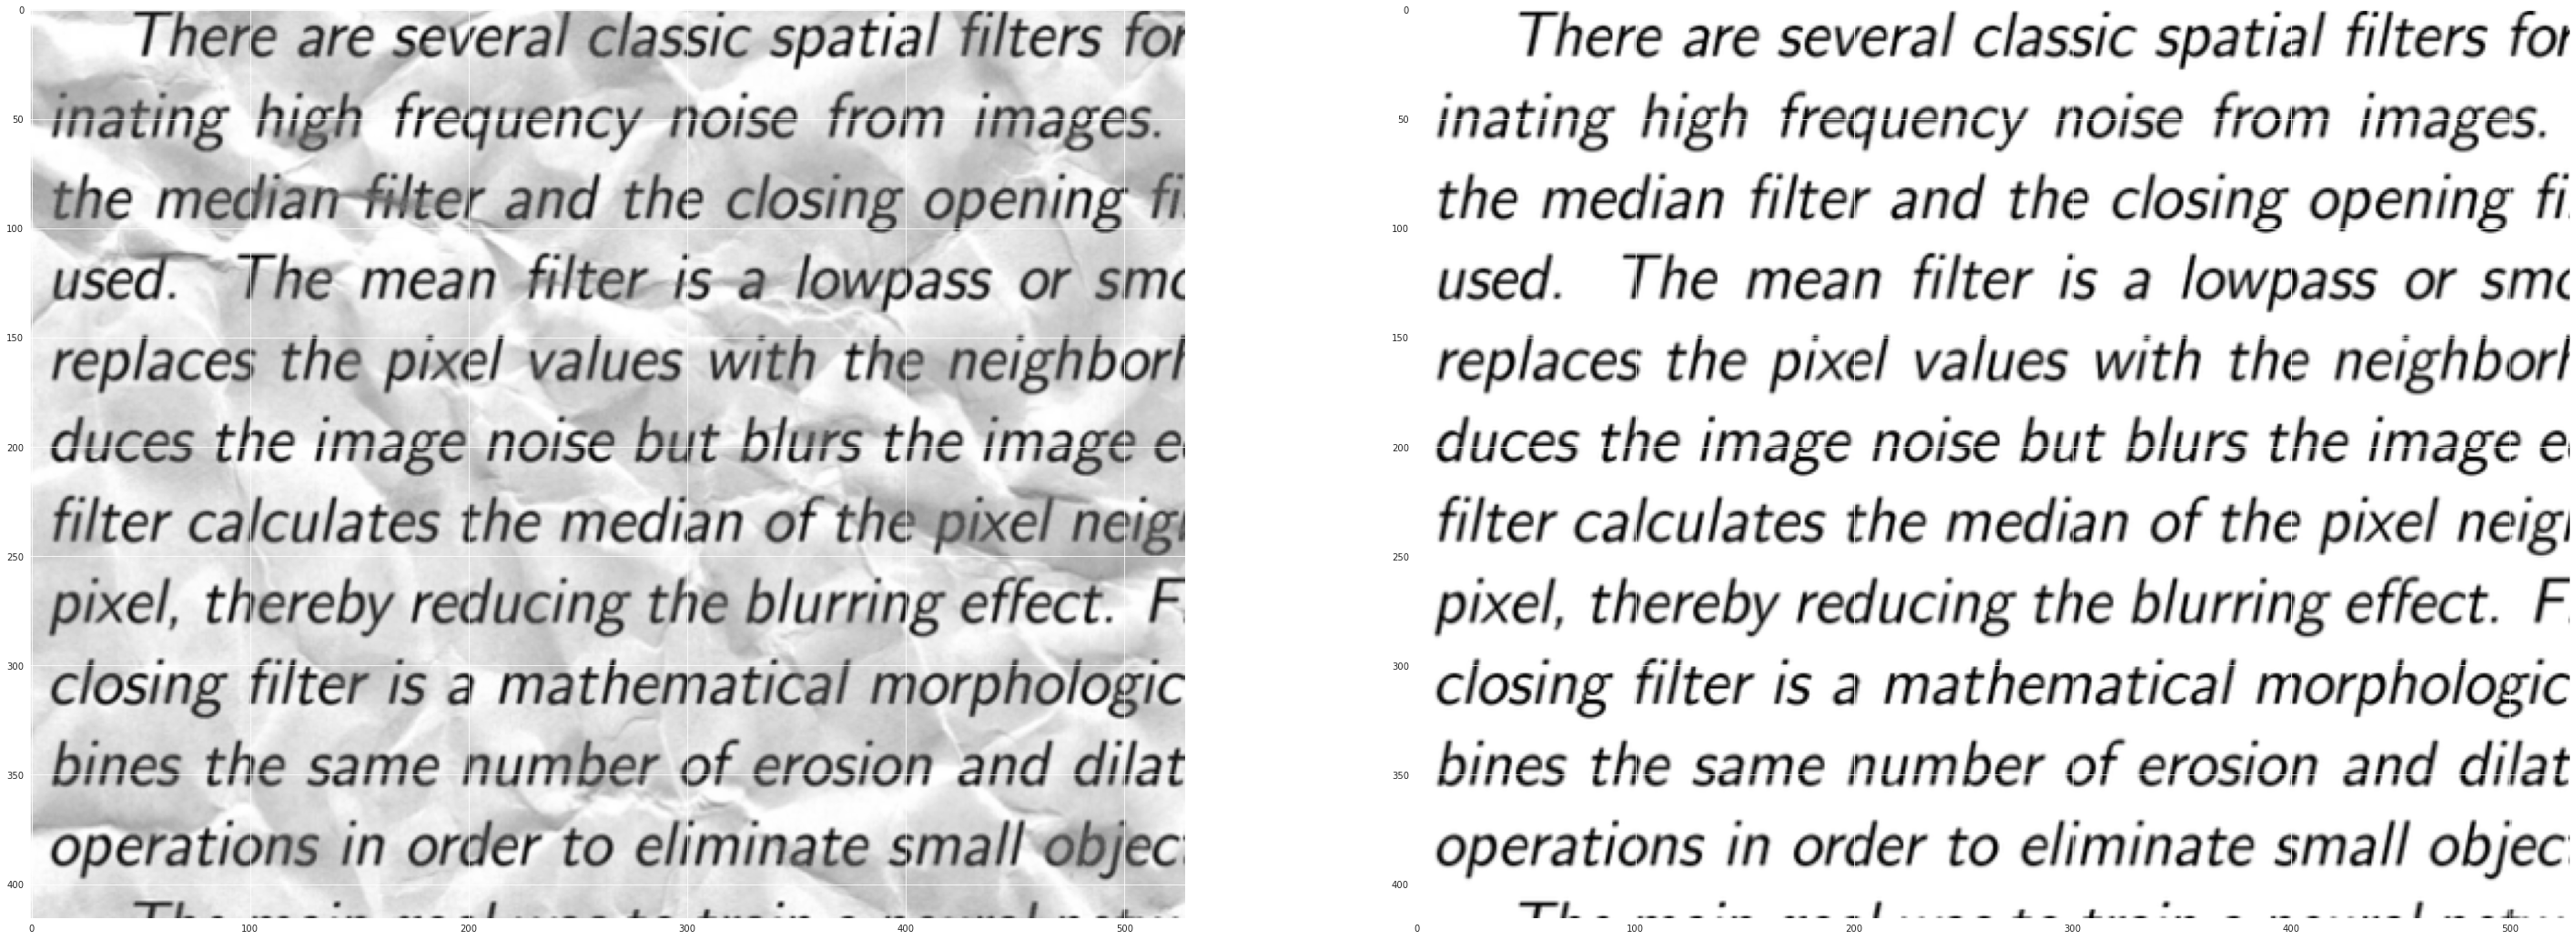

In [84]:
a = DataLoader_Class(path_zip, path)
b = a.read_all_image()
a.see_an_image(5)

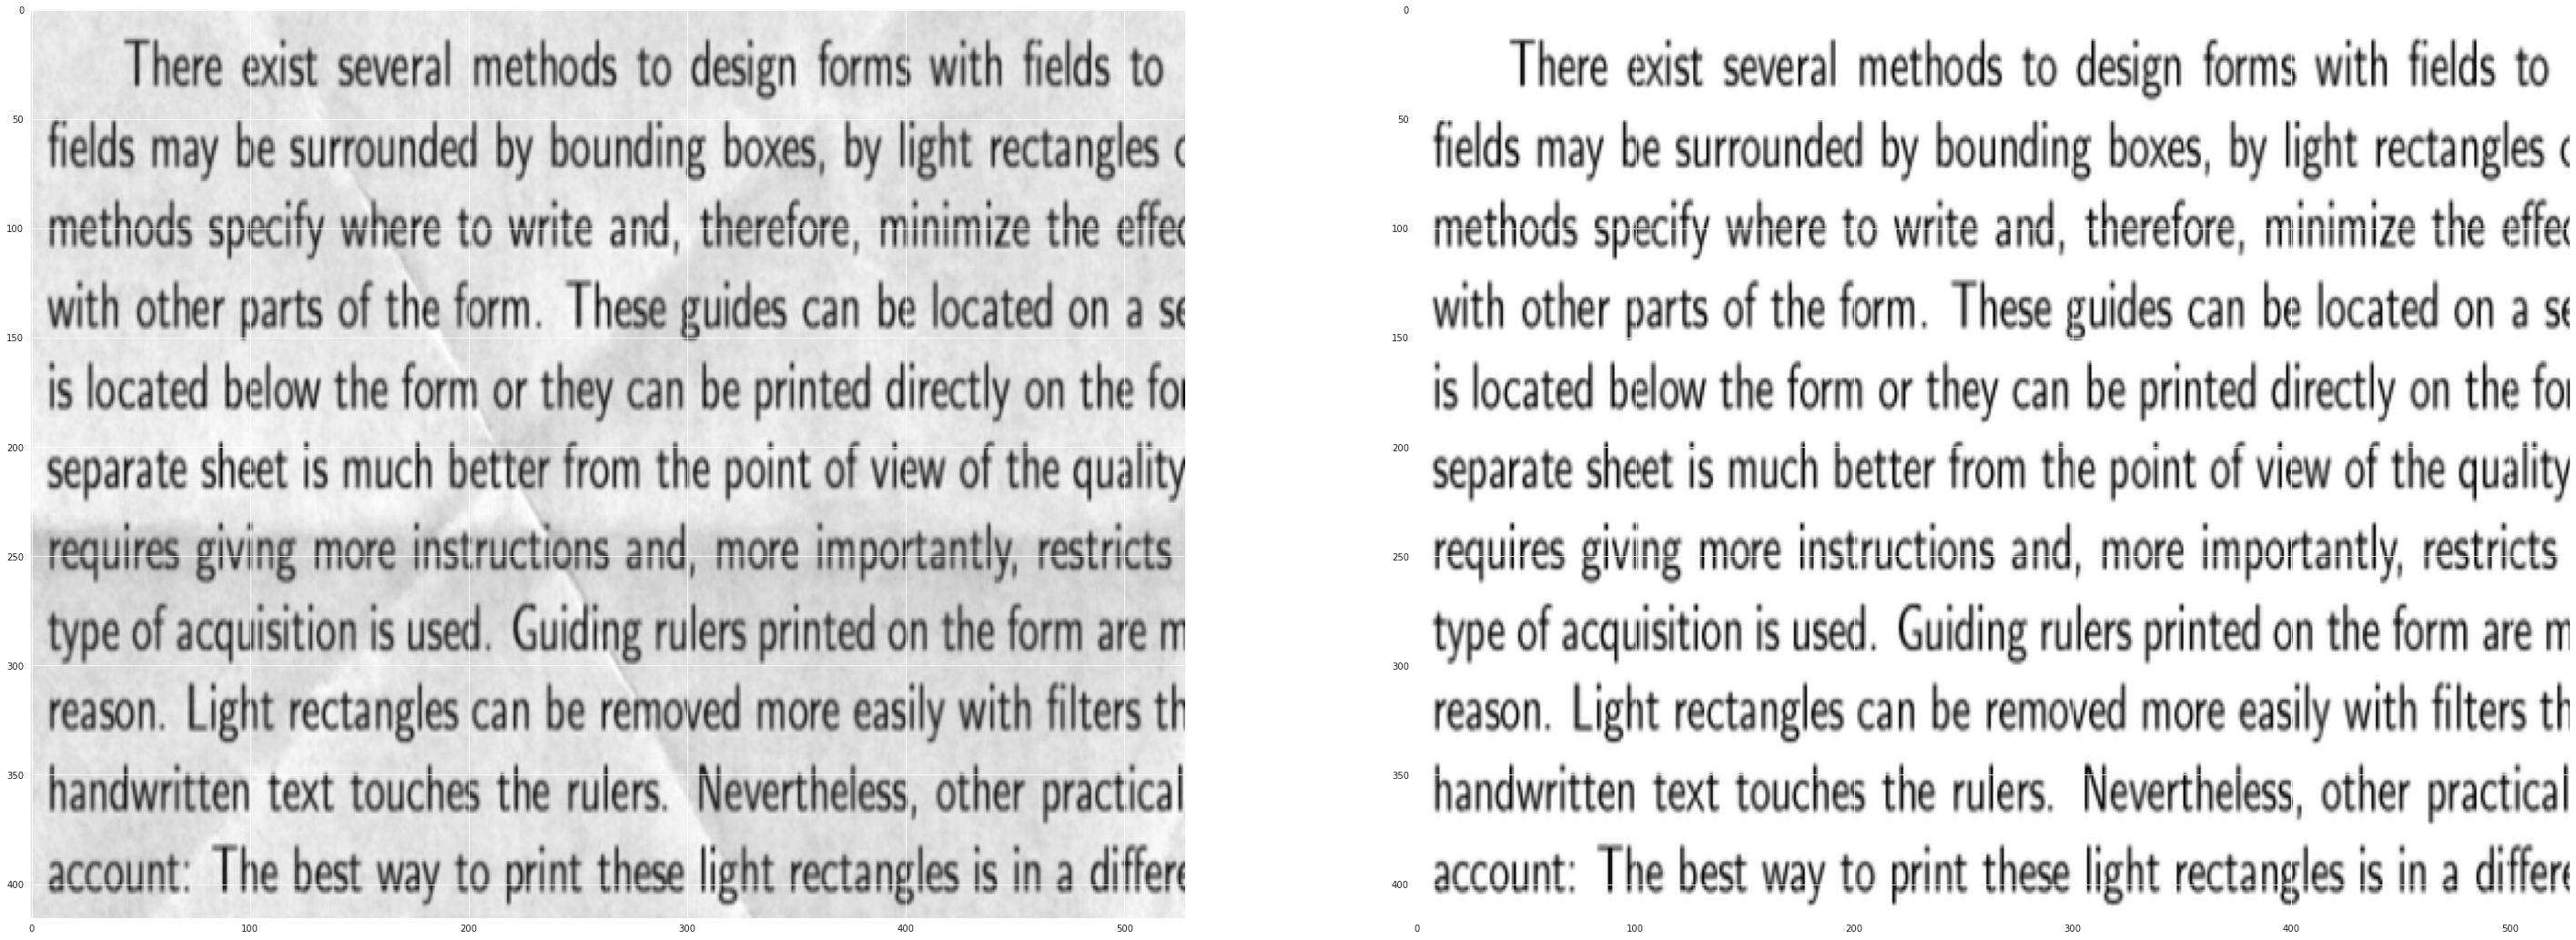

In [85]:
a.see_an_image(100)

In [86]:
"""
train_test_x train_test_y
train_set_x  train_set_y
test_set_x 
"""


'\ntrain_test_x train_test_y\ntrain_set_x  train_set_y\ntest_set_x \n'

cuda:0
Epoch:1, Loss:0.1866
Epoch:2, Loss:0.1381
Epoch:3, Loss:0.1313
Epoch:4, Loss:0.1031
Epoch:5, Loss:0.1205
Epoch:6, Loss:0.0704
Epoch:7, Loss:0.0665
Epoch:8, Loss:0.0733
Epoch:9, Loss:0.0934
Epoch:10, Loss:0.0565
Epoch:11, Loss:0.0565
Epoch:12, Loss:0.0595
Epoch:13, Loss:0.0566
Epoch:14, Loss:0.0552
Epoch:15, Loss:0.0548
Epoch:16, Loss:0.0572
Epoch:17, Loss:0.0443
Epoch:18, Loss:0.0488
Epoch:19, Loss:0.0732
Epoch:20, Loss:0.0534
(1, 416, 528)
[[[0.86930776 0.9252822  0.92250276 ... 0.9726553  0.9690308  0.87277484]
  [0.9654116  0.99016094 0.99216324 ... 0.9937448  0.9869543  0.9513379 ]
  [0.95809495 0.99250185 0.9935148  ... 0.999629   0.9997187  0.99170846]
  ...
  [0.9769453  0.9950537  0.9935202  ... 0.92776203 0.98264575 0.9394969 ]
  [0.9931439  0.9988663  0.9985734  ... 0.9996964  0.9999176  0.9971641 ]
  [0.88974535 0.9615982  0.9453537  ... 0.9691057  0.9748086  0.93153244]]]
<class 'torch.Tensor'>


NameError: name 'ö' is not defined

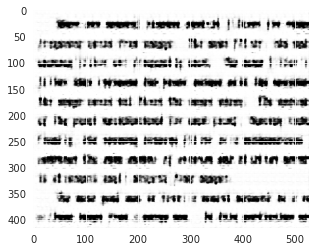

In [107]:
batch_size = 2

from torch.utils.data import Dataset

class Dataset96(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
training_set = Dataset96(train_set_x, train_set_y)
train_loader = torch.utils.data.DataLoader(training_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_set = Dataset96(train_test_x, train_test_y)
test_loader  = torch.utils.data.DataLoader(test_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 512, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  
        self.dec2 = nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(128, 256, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2)
        self.out = nn.Conv2d(512, 1, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)        
        self.pool = nn.MaxPool2d(2, 2)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.bn4(x)
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = (self.bn4(x))
        x = F.relu(self.dec2(x))
        x = (self.bn3(x))
        x = F.relu(self.dec3(x))
        x = (self.bn2(x))
        x = F.relu(self.dec4(x))
        x = (self.bn1(x))
        x = torch.sigmoid(self.out(x))
        return x
def train(model, num_epochs=5, batch_size=2, learning_rate=0.01):
    criterion = nn.MSELoss() # mean square error loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    
    outputs = []

    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            
            #print(_)
            img, _ = img.cuda(), _.cuda()

            optimizer.zero_grad()
            recon = model(img)
            #print(recon.shape)
            loss = criterion(recon, _)
            loss.backward()
            optimizer.step()
            
            
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

model = Autoencoder()
device = get_device()
print(device)
model.to(device)

outputs = train(model, num_epochs=20)

recon = outputs[1][2].detach().cpu().numpy()
for i in recon:
    print(i.shape)
    #i = i.reshape(-1,540)
    print(i)
    i =  torch.from_numpy(i)
    #lum_img = img[:, :, 0]
    print(type(i))
    plt.imshow(i.permute(1,2,0),cmap = "gray")
    break



(1, 416, 528)
[[[0.94839394 0.973111   0.9793808  ... 0.9623514  0.9867557  0.96544856]
  [0.9752759  0.990248   0.99030674 ... 0.98386776 0.9936837  0.97296786]
  [0.9735772  0.98909366 0.9863665  ... 0.9872299  0.99465346 0.964985  ]
  ...
  [0.94379526 0.98967487 0.99285465 ... 0.7889204  0.30923674 0.40506923]
  [0.95202    0.99443793 0.9968784  ... 0.9872273  0.98181206 0.9192094 ]
  [0.80821395 0.94924295 0.9620985  ... 0.91888505 0.93501157 0.84335667]]]
<class 'torch.Tensor'>


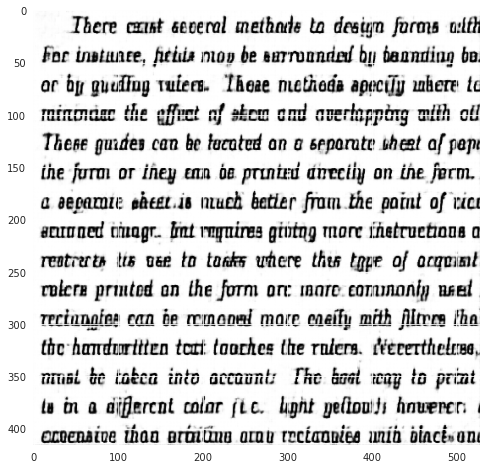

In [129]:
recon = outputs[9][2].detach().cpu().numpy()
for i in recon:
    print(i.shape)
    #i = i.reshape(-1,540)
    print(i)
    i =  torch.from_numpy(i)
    #lum_img = img[:, :, 0]
    print(type(i))
    fig = plt.figure()
    fig.set_size_inches(8,8)
    a = i.permute(1,2,0)
    plt.imshow(a ,cmap = "gray", aspect='auto')

    break